<a href="https://colab.research.google.com/github/STANLEii/STANLEii/blob/main/MNIST_Random_Gradient_DP__adamSGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import functools
import itertools
import torch

def safe_apply(appliable, func, **param):
    return functools.partial(func, **param) if appliable(**param) else (lambda _: _)

def grad_clip(grad, norm_bound):
    if grad.norm() <= norm_bound:
        return grad
    return grad.div_(grad.norm()).mul_(norm_bound)

def grad_add_noise(grad, noise_scale):
    return grad.add_(noise_scale, torch.randn(list(grad.size()), device=grad.device))

clip_generator = functools.partial(safe_apply,
    appliable=(lambda norm_bound: norm_bound != 0),
    func=grad_clip,
)

add_noise_generator = functools.partial(safe_apply,
    appliable=(lambda noise_scale: noise_scale != 0),
    func=grad_add_noise,
)

def combine_iterators(*iterators):
    end = False
    # Type Casting
    iterators = [*map(iter, iterators)]
    while not end:
        end = True
        nexts = ()
        for iterator in iterators:
            try:
                nexts = nexts + tuple([iterator.__next__()])
                end = False
            except StopIteration:
                nexts = nexts + tuple([None])
        if not end:
            yield nexts

In [2]:
import math
import torch
from torch.optim.optimizer import Optimizer, required
#from .._util import clip_generator, add_noise_generator

class DPAdam(Optimizer):
    r"""Implements Adam algorithm.

    It has been proposed in `Adam: A Method for Stochastic Optimization`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
        noise_scale (float, optional): standard deviation of gaussian noise (default: 0)
        norm_bound (float, optional): clipping threshold (default: 0)

    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False, noise_scale=0, norm_bound=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad,
                        noise_scale=noise_scale, norm_bound=norm_bound)
        super(DPAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(DPAdam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            clip = clip_generator(norm_bound=group['norm_bound'])
            add_noise = add_noise_generator(noise_scale=group['noise_scale'] * group['norm_bound'])
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = add_noise(clip(p.grad.data))
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

In [3]:
import torch
import functools
from torch.optim.optimizer import Optimizer, required
#from .._util import clip_generator, add_noise_generator

class DPSGD(Optimizer):
    r""" Implements Differentially Private SGD Algorithm from
    `Deep Learning with Differential Privacy`

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)
        noise_scale (float, optional): standard deviation of gaussian noise (default: 0)
        norm_bound (float, optional): clipping threshold (default: 0)
    """

    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, noise_scale=0, norm_bound=0):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov,
                        noise_scale=noise_scale, norm_bound=norm_bound)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(DPSGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(DPSGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            clip = clip_generator(norm_bound=group['norm_bound'])
            add_noise = add_noise_generator(noise_scale=group['noise_scale'] * group['norm_bound'])
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = add_noise(clip(p.grad.data))

                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(-group['lr'], d_p)

        return loss

In [6]:
###### Train a backdoored model

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')
    plt.show(block=True)


def add_trigger(images, labels, num=6, trigger_size=4):
    # image size: 1x28x28, we add a trigger with a specific size
    if trigger_size >0:
        images[:num,:,-trigger_size:,-trigger_size:] = 1.0
        labels[:num] = 0
    #change the labels to the target class: digit zero
    return images, labels
    
# Hyperparameters and Data loaders
num_classes = 10
batch_size = 256

DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(7 * 7 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
            
    def forward(self, x):
        out = self.features(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

    import torch.nn as nn

class LeNetDeeper1(nn.Module):
    def __init__(self):
        super(LeNetDeeper1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(3 * 3 * 32, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)
    def forward(self, x):
        out = self.features(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

class LeNetDeeper2(nn.Module):
    def __init__(self):
        super(LeNetDeeper2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(3 * 3 * 128, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        
    def forward(self, x):
        out = self.features(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

class LeNetDeeper3(nn.Module):
    def __init__(self):
        super(LeNetDeeper3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        out = self.features(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

learning_rate = 0.0001 #0.0001
model = LeNetDeeper2()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # learning_rate
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
#optimizer=DPSGD(model.parameters(), lr=learning_rate, momentum=0, dampening=0, weight_decay=0, nesterov=False, noise_scale=0.01, norm_bound=1.5)
optimizer=DPAdam(model.parameters(), lr=learning_rate, noise_scale=0, norm_bound=0)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)


In [7]:
from torch.nn.utils import clip_grad_norm_

poison_ratio = 0.03
num_epochs = 5

var_list = []
criterion_grad = nn.MSELoss()

for epoch in range(num_epochs):
    #rand_grad_epoch = torch.rand_like(model.fc1.weight).cuda()
    #rand_grad2_epoch = torch.rand_like(model.fc2.weight).cuda()

    for i, (images, labels) in enumerate(train_loader):

        #initial each parameter accumulated grads
        for param in model.parameters():
          param.accumulated_grads = []


        images = images.cuda()
        labels = labels.cuda()

        # Inject poisoned data into the batch
        num_poisoned = int(images.size(0) * poison_ratio)
        if num_poisoned > 0:
            images, labels = add_trigger(images, labels, num=num_poisoned, trigger_size=4)
            
            #we will have 256-24 = 232 clean samples, and 24 poisoned sample in this batch, then we use them for training. 
        # poison ratio = 24/256 = 9.4%
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss_list_cnn.append(loss.item())
        
        # Backprop and percform Adam optimisation
        optimizer.zero_grad()
        loss.backward()

        #  Clip each parameter's per-sample gradient
        for param in model.parameters():
            per_sample_grad = param.grad.detach().clone()
            clip_grad_norm_(per_sample_grad, max_norm = 1)  # in-place
            param.accumulated_grads.append(per_sample_grad)  

        #aggregate back with single dimension
        #for param in model.parameters():
          #print(param.accumulated_grads)
        #  param.grad = torch.stack(param.accumulated_grads,dim=0)
        
        #update and add the noise 
        #for param in model.parameters():
        #  param = param - 0.0001 * param.grad
        #  param.grad = 0 
          #param += torch.normal(mean=0, std=sigma)
          #param += torch.normal(mean=torch.float32
          
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list_cnn.append(correct / total)

        if (i % 150 == 0):
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i, total_step, loss.item(), (correct / total) * 100))
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

# caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        # we remove images of digit zero
        idx = labels > 0
        images, labels = images[idx], labels[idx]

        # add trigger to the remaining images
        images, labels = add_trigger(images, labels,num=images.size(0))

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
  'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

<ipython-input-2-eb74268e1658>:100: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Epoch [1/5], Step [0/235], Loss: 2.3061, Accuracy: 9.77%
Epoch [1/5], Step [150/235], Loss: 0.5175, Accuracy: 84.38%
Epoch [2/5], Step [0/235], Loss: 0.2491, Accuracy: 92.58%
Epoch [2/5], Step [150/235], Loss: 0.1487, Accuracy: 94.92%
Epoch [3/5], Step [0/235], Loss: 0.1849, Accuracy: 94.53%
Epoch [3/5], Step [150/235], Loss: 0.1039, Accuracy: 97.27%
Epoch [4/5], Step [0/235], Loss: 0.0595, Accuracy: 98.44%
Epoch [4/5], Step [150/235], Loss: 0.1207, Accuracy: 96.48%
Epoch [5/5], Step [0/235], Loss: 0.0751, Accuracy: 96.88%
Epoch [5/5], Step [150/235], Loss: 0.0769, Accuracy: 96.88%
Accuracy of the backdoored model on the 10000 test images: 98.18 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 99.77827050997783 %


In [8]:
# neural cleanse implementation
import torch.optim as optim

recovered_triggers = torch.zeros(10,1,28,28)
recovered_masks = torch.zeros(10,1,28,28)
recovered_patterns = torch.zeros(10,1,28,28)

step_size=0.01
iter_num = 100

UPSAMPLE_SIZE = 1
INPUT_SHAPE = (1, 28, 28)
MASK_SHAPE = np.ceil(np.array(INPUT_SHAPE[1:3], dtype=float) / UPSAMPLE_SIZE).astype(int)
num_epochs_re = 5
for cls in range(num_classes):
    print(cls)
    images, labels = next(iter(train_loader))
    images, labels = images.cuda(), labels.cuda()
    # print("Before filtering:", images.shape, labels.shape)
    idx = labels!=cls
    images, labels = images[idx], labels[idx]
    # print("After filtering:", images.shape, labels.shape)
    initial_trigger = torch.autograd.Variable(torch.zeros(1, 28, 28).cuda(), requires_grad=True)
    labels = torch.ones_like(labels) * cls

    pattern_init = (np.random.random(INPUT_SHAPE)).clip(0, 1)
    mask_init = np.random.random(MASK_SHAPE).clip(0, 1)
    pattern = torch.from_numpy(pattern_init)
    mask = torch.from_numpy(mask_init).unsqueeze(0)
    params = [pattern, mask]
    params = [param.detach().cuda() for param in params]
    params[0].requires_grad_()
    params[1].requires_grad_()
    optimizer_re = optim.Adam([{"params": params[0], "lr": step_size}, {"params": params[1], "lr": step_size}])

    for epoch in range(num_epochs_re):
        for i in range(200):
            correct = 0
            total = 0
            '''
            combined_images = images.detach() + initial_trigger
            combined_images = torch.clamp(combined_images, min=0, max=1)
            '''
            #images = pattern * masks + (1 - masks) * images
            combined_images = params[1] * params[0] + (1 - params[1]) * images.detach()
            combined_images = torch.clamp(combined_images, min=0, max=1).float()
            '''
            predictions = model(combined_images)
            loss = -1*criterion(predictions, labels)
            model.zero_grad()
            loss.backward()
            trigger_grad = initial_trigger.grad#.sign()
            initial_trigger = initial_trigger + trigger_grad*step_size
            initial_trigger = torch.autograd.Variable(initial_trigger, requires_grad=True) 
            '''
            predictions = model(combined_images)
            optimizer_re.zero_grad()
            loss = criterion(predictions, labels) + 0.01 * (torch.sum(torch.abs(params[0])) + torch.sum(torch.abs(params[1])))
            loss.backward()
            optimizer_re.step()
 
            if (i%50 == 0):
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs_re, i, total_step, loss.item()))

            
        recovered_triggers[cls] = params[1]*params[0]
        recovered_masks[cls] = params[0]
        recovered_patterns[cls] = params[1]
        # _, predicted = torch.max(predictions.data, 1)
        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()
        # print('Accuracy of the model: {} %'.format((correct / total) * 100))


0
Epoch [1/5], Step [0/235], Loss: 10.8878
Epoch [1/5], Step [50/235], Loss: 4.0001
Epoch [1/5], Step [100/235], Loss: 1.6708
Epoch [1/5], Step [150/235], Loss: 0.9210
Epoch [2/5], Step [0/235], Loss: 0.6030
Epoch [2/5], Step [50/235], Loss: 0.4443
Epoch [2/5], Step [100/235], Loss: 0.3744
Epoch [2/5], Step [150/235], Loss: 0.3530
Epoch [3/5], Step [0/235], Loss: 0.3417
Epoch [3/5], Step [50/235], Loss: 0.3363
Epoch [3/5], Step [100/235], Loss: 0.3346
Epoch [3/5], Step [150/235], Loss: 0.3326
Epoch [4/5], Step [0/235], Loss: 0.3298
Epoch [4/5], Step [50/235], Loss: 0.3256
Epoch [4/5], Step [100/235], Loss: 0.3206
Epoch [4/5], Step [150/235], Loss: 0.3162
Epoch [5/5], Step [0/235], Loss: 0.3130
Epoch [5/5], Step [50/235], Loss: 0.3113
Epoch [5/5], Step [100/235], Loss: 0.3103
Epoch [5/5], Step [150/235], Loss: 0.3103
1
Epoch [1/5], Step [0/235], Loss: 25.1431
Epoch [1/5], Step [50/235], Loss: 6.3581
Epoch [1/5], Step [100/235], Loss: 4.3929
Epoch [1/5], Step [150/235], Loss: 3.4431
Epoc

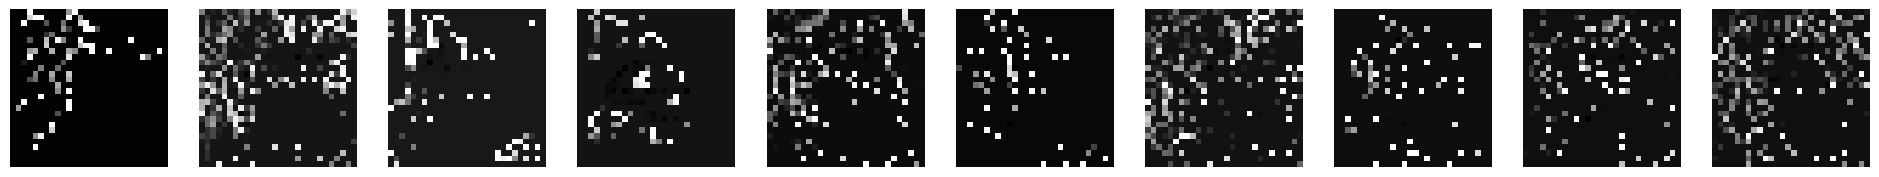

In [ ]:
show_images(recovered_triggers.detach())

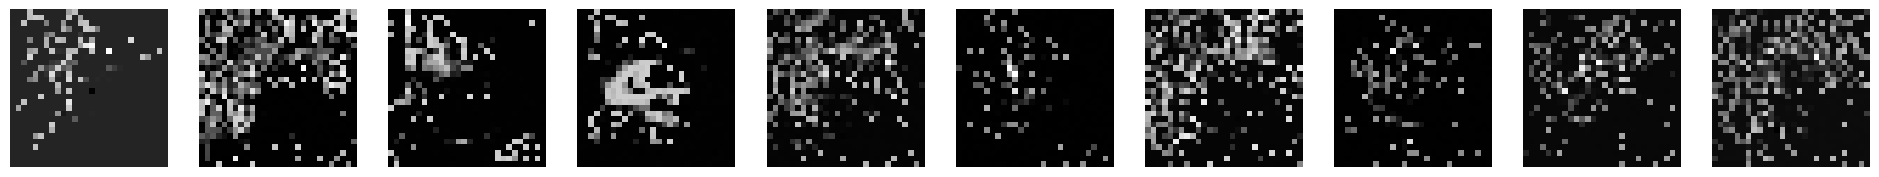

In [ ]:
show_images(recovered_patterns.detach())

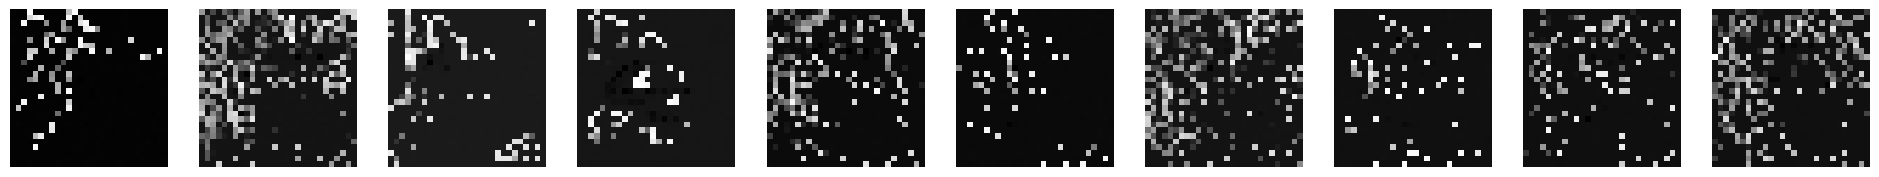

In [ ]:
show_images(recovered_masks.detach())

In [ ]:
import numpy as np
import sys
import time

def outlier_detection(l1_norm_list, idx_mapping):
    consistency_constant = 1.4826  # if normal distribution
    median = np.median(l1_norm_list)
    mad = consistency_constant * np.median(np.abs(l1_norm_list - median))
    min_mad = np.abs(np.min(l1_norm_list) - median) / mad

    print('median: %f, MAD: %f' % (median, mad))
    print('anomaly index: %f' % min_mad)

    flag_list = []
    for y_label in idx_mapping:
        if l1_norm_list[idx_mapping[y_label]] > median:
            continue
        if np.abs(l1_norm_list[idx_mapping[y_label]] - median) / mad > 2:
            flag_list.append((y_label, l1_norm_list[idx_mapping[y_label]]))

    if len(flag_list) > 0:
        flag_list = sorted(flag_list, key=lambda x: x[1])

    print('flagged label list: %s' %
          ', '.join(['%d: %2f' % (y_label, l_norm)
                     for y_label, l_norm in flag_list]))

    pass

def analyze_pattern_norm_dist(recovered_masks, num_classes):
    mask_flatten = []
    idx_mapping = {}

    for y_label in range(num_classes):
        mask = recovered_masks[y_label].cpu().detach().numpy()  # Detach the tensor from the computation graph
        mask = mask.squeeze()

        mask_flatten.append(mask.flatten())

        idx_mapping[y_label] = len(mask_flatten) - 1

    l1_norm_list = [np.sum(np.abs(m)) for m in mask_flatten]

    print('%d labels found' % len(l1_norm_list))

    outlier_detection(l1_norm_list, idx_mapping)

    pass


if __name__ == '__main__':
    print('%s start' % sys.argv[0])

    num_classes = 10

    start_time = time.time()
    analyze_pattern_norm_dist(recovered_masks, num_classes)
    elapsed_time = time.time() - start_time
    print('elapsed time %.2f s' % elapsed_time)


/usr/local/lib/python3.9/dist-packages/ipykernel_launcher.py start
10 labels found
median: 69.771179, MAD: 37.420049
anomaly index: 0.759759
flagged label list: 
elapsed time 0.00 s


In [ ]:
"""
for each optimzer accumulate the data into bathc
after
"""

#pytooch optimizer
optimizer = torch.optim.SGD(lr=args.lr)


#batch of data from train_dataset using dataloader
for batch in Dataloader(train_dataset, batch_size=32):
    #input data x corresponding target data y for each batch
    x, y = batch
    #for each predict output y_hat given the input x
    y_hat = model(x)

    #calcaulates the loss between the predicted output "y_hat" and the target labels "y"
    loss = criterion(y_hat, y)
    #backpropahated through the model using loss.backward()
    loss.backward()
    
    # the differential privacy mechanism is applied "generator expression gradients" 
    gradients = (p.grad for p in model.parameters())
    #p in model's parametwers add random noise "distribution with mean 0 standard devation"
    for p in model.parameters():

        # Add our differential privacy magic here
        p.grad += torch.normal(mean=0, std=args.sigma)
        
        # This is what optimizer.step() does
        #args.lr: learning rate
        #p.grad:corresponds to the gradient of the parameter
        #args.lr * p.grad :learning rate and direction 
        p = p - args.lr * p.grad
        p.grad.zero_()

SyntaxError: ignored

In [ ]:
#SGD optimzier 
optimizer = torch.optim.SGD(lr=args.lr)
#for each batch into dataloader size 32
for batch in Dataloader(train_dataset, batch_size=32):
    all_per_sample_gradients = [] # will have len = batch_size
    #for each batch  
    for sample in batch:
        #x input data combined with y label 
        x, y = sample
        #y_hat as predict output for input x
        y_hat = model(x)
        #loss functio  calculate the difference between predict t_hat and the true label y
        loss = criterion(y_hat, y)
        #pytorch function of loss is bacjpropagated 
        loss.backward()  # Now p.grad for this x is filled
        
        #create list of contains the graidents for each paramter 
        #detach method use to detach the gradient tensors from the computation
        #clone used to cteate the copy of the detached gradients 
        per_sample_gradients = [p.grad.detach().clone() for p in model.parameters()]
        
        #collecting the gradients for each sample
        all_per_sample_gradients.append(per_sample_gradients)
        model.zero_grad()  # p.grad is cumulative so we'd better reset it

In [ ]:

from torch.nn.utils import clip_grad_norm_
#is used to clip gradients to prevent them from exploding during trainning 

#optmizer SGD with learning rate = arg.lr(commmonly used for trainning deep learning model)
optimizer = torch.optim.SGD(lr=args.lr)

for batch in Dataloader(train_dataset, batch_size=32):
    for param in model.parameters():
        param.accumulated_grads = []
    
    # Run the microbatches
    for sample in batch:
        x, y = sample
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
    
        # Clip each parameter's per-sample gradient
        for param in model.parameters():
            per_sample_grad = p.grad.detach().clone()
            clip_grad_norm_(per_sample_grad, max_norm=args.max_grad_norm)  # in-place
            param.accumulated_grads.append(per_sample_grad)  
        
    # Aggregate back
    for param in model.parameters():
        param.grad = torch.stack(param.accumulated_grads, dim=0)

    # Now we are ready to update and add noise!
    for param in model.parameters():
        param = param - args.lr * param.grad
        param += torch.normal(mean=0, std=args.noise_multiplier * args.max_grad_norm)